<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2020/sem08/real_expect.png" width="800">

# Андан на экономе: домашнее задание 2
</center>


**ФИО:**

**[2 бонусных балла] прикрепите к работе самый крутой мем из своих сохранёнок:**

## Общая информация

__Дата выдачи:__ 27.01.2025

__Мягкий дедлайн:__ 23:59MSK 23.02.2025

__Жесткий дедлайн:__ 23:59MSK 02.03.2025

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

В этой домашке мы с вами:

1. Посмотрим какимы бывают доверительные интервалы для долей
2. Вспомним квантильное преобразование и сгенерируем распределение максимума
3. Построим метрику плохих показов, происследуем её на смещенность и исправим её

## Задача 1: Доверительные интервалы для долей (30 баллов)

В этой задаче вам предстоит поработать с разными видами доверительных интервалов для долей.

Пусть случайные величины $X_1, \ldots, X_n$ независимы и имеют распределение Бернулли с неизвестным параметром $p$, при этом $\hat p = \bar x$.

__а) [10 баллов]__ Если воспользоваться ЦПТ, можно построить для неизвестного $p$ доверительный интервал Вальда. На паре мы для этого использовали сходимость

$$
\frac{\hat p - p}{\sqrt{\frac{\hat p (1 - \hat p)}{n}}} \to N(0;1),
$$

а затем решали неравенство
$$
-z_{cr} \leq \frac{\hat p - p}{\sqrt{\frac{\hat p (1 - \hat p)}{n}}} \leq z_{cr}.
$$

Получалось, что при уровне значимости $\alpha,$ доверительный интервал

$$
\hat p \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{ \frac{\hat p \cdot (1 - \hat p)}{n} }
$$

накрывает неизвестное значение $p$ с вероятностью $1 - \alpha$.

В этом задании мы, с помощью симуляций на компьютере, сравним фактическую вероятность накрытия неизвестного параметра $p$ интервалами Вальда, Вильсона и Агрести—Коулла c номинальной 95\%-й вероятностью.

### Сеттинг симуляций:

1. Зафиксируем уровень значимости равный $5\%$
2. Будем перебирать $p$ в интервале $(0, 1)$ с шагом в 0.01
3. Для каждого p проведем $1000$ симуляций
    - генерируем с заданным $p$ выборку размера $n = 10$
    - строим доверительный интервал для $p$
    - cмотрим попадает ли истинное значение в доверительный интервал
4. Оцениваем по симуляциям получившийся уровень значимости (доля случаев, когда доверительный интервал не покрыл $p$).
5. Рисуем картинку, где по оси абсцис отложены значения $p$, а по оси ординат полученная оценка уровня значимости. Отдельной пунктирной линией рисуем на картинке $0.05$.

Картинка должна получиться примерно такой же как [в этой статье.](https://www.ime.usp.br/~jmsinger/Textos/Castroetal2019.pdf)

In [2]:
def ci_wald(p, n_obs=10, alpha=0.05, n=1000):
    z = sts.norm().ppf(1 - alpha/2)
    x = sts.bernoulli.rvs(p, size=(n, n_obs))
    p_hat = x.mean(axis=1)
    std_hat = np.sqrt(p_hat * (1 - p_hat) / n_obs)
    left = p_hat - z * std_hat
    right = p_hat + z * std_hat
    error = 1 - np.mean((left < p) & (p < right))
    length = np.mean(right - left)
    return error, length

In [3]:
# за циклы тут не караем, главное смысл
p = np.arange(0, 1.01, 0.01)
err_wald, length_wald = np.vectorize(ci_wald)(p)

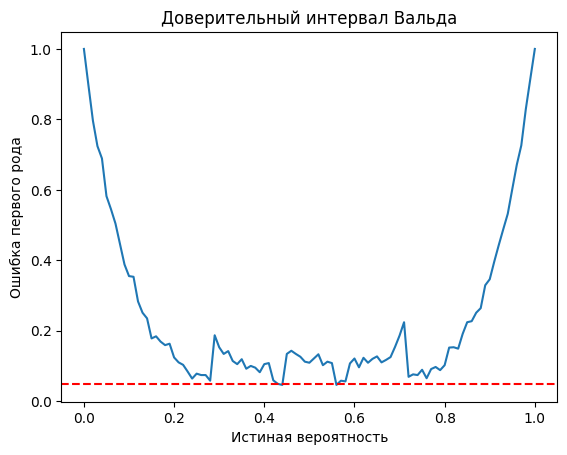

In [4]:
plt.plot(p, err_wald)
plt.axhline(0.05, color='red', linestyle='dashed')
plt.xlabel('Истиная вероятность')
plt.ylabel('Ошибка первого рода')
plt.title('Доверительный интервал Вальда');

__б) [5 баллов]__ Можно не заменять в дисперсии значения $p$ на $\hat p$, а вместо этого воспользоваться сходимостью

$$
\frac{\hat p - p}{\sqrt{\frac{p (1 - p)}{n}}} \to N(0;1)
$$

и решить относительно неизвестного $p$ (о ужас!) квадратное неравенство. Выйдет доверительный интервал Уилсона:

$$
\hat p_w \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{u \hat p (1 - \hat p) + (1 - u) (1/2)^2 }{n_w}},
$$
где $\quad$ $\hat p_w = u \hat p + (1 - u) (1/2)$, $\quad$  $u = \frac{n}{n + z_{1 - \frac{\alpha}{2}}^2}$, $\quad$ $(1-u) = \frac{z_{1 - \frac{\alpha}{2}}^2}{n + z_{1 - \frac{\alpha}{2}}^2}$,  $\quad$
  $n_w = n + z_{1 - \frac{\alpha}{2}}^2$.

**Необязательно:** с помощью ручки и бумаги убедитесь, что эти формулы верны.

In [5]:
def ci_wilson(p, n_obs=10, alpha=0.05, n=1000):
    z = sts.norm().ppf(1 - alpha/2)
    x = sts.bernoulli.rvs(p, size=(n, n_obs))

    p_hat = x.mean(axis=1)
    u = n_obs / (n_obs + z**2)
    n_w = n_obs + z**2
    p_hat_w = u * p_hat + (1 - u) * 0.5

    std_hat = np.sqrt((u * p_hat * (1 - p_hat) + (1 - u) * (0.5 **2 )) / n_w)
    left = p_hat_w - z * std_hat
    right = p_hat_w + z * std_hat

    error = 1 - np.mean((left < p) & (p < right))
    length = np.mean(right - left)
    return error, length

Повторите для доверительного интервала Уилсона тот же самый эксперимент и постройте картинку с поведением уровня значимости в зависимости от значений $p$.

In [6]:
# за циклы тут не караем, главное смысл
p = np.arange(0, 1.01, 0.01)
err_wilson, length_wilson = np.vectorize(ci_wilson)(p)

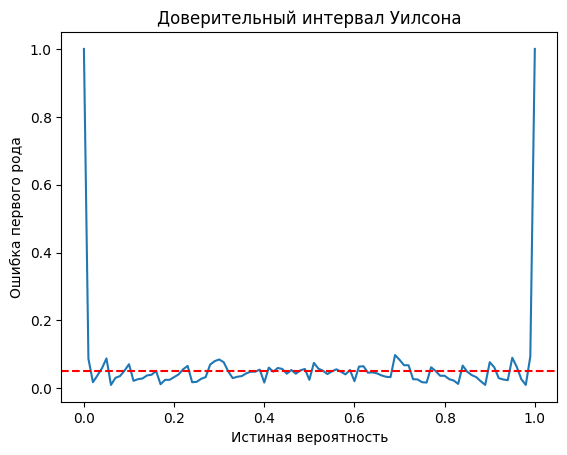

In [7]:
plt.plot(p, err_wilson)
plt.axhline(0.05, color='red', linestyle='dashed')
plt.xlabel('Истиная вероятность')
plt.ylabel('Ошибка первого рода')
plt.title('Доверительный интервал Уилсона');

### Блок необязательных заданий

> Эти задания вы можете попытаться решить на бумаге сами. Если вам лень это делать, достаточно их прочитать и как следует осмыслить ответы.

**Задание 1:**

Обозначим центр интервала Вильсона с помощью $\hat p_w$. С помощью ручки и  бумаги докажите, что центр интервала Вильсона $\hat p_w$ можно представить как средневзвешенное классической оценки $\hat p$ и тривиальной оценки $1/2$,

$$
\hat p_w = u \cdot \hat p + (1 - u) \cdot (1/2).  
$$

Найдите веса $u$ и $(1-u)$.

**Ответ:**  $u = \frac{n}{n + z_{cr}^2}$, $\quad$ $(1-u) = \frac{z_{cr}^2}{n + z_{cr}^2}$.

**Задание 2:**  Докажите, что центр интервала Вильсона $\hat p_w$ можно проинтерпретировать следующим образом: добавим $f$ вымышленных $1$ и $f$ вымышленных $0$ в выборку и посчитаем классическую оценку вероятности для выборки с вымышленными наблюдениями,

$$
\hat p_w = \frac{\sum_{i=1}^n Y_i + f}{n + 2 f}.
$$

Какому целому числу примерно равно $f$ для 95\%-го доверительного интервала?

__Ответ:__

$$
\hat p_w = \frac{\sum Y_i + z_{cr}^2/2}{n + z_{cr}^2},
$$

то есть мы добавляем в выборку $f = z_{cr}^2/2$ вымышленных $1$ и столько же вымышленных $0$.

**Задание 3:**  Докажите, что интервал Вильсона можно записать в виде

$$
\hat p_w \pm z_{cr} \cdot \sqrt{\frac{u \cdot \hat p (1 - \hat p) + (1 - u) \cdot (1/2)^2 }{n_w}}.
$$

Найдите $n_w$, а также веса $u$ и $(1 - u)$.

__Ответ:__

$\hat p_w = u \cdot \hat p + (1 - u) \cdot (1/2)$, $\quad$ $u = \frac{n}{n + z_{cr}^2}$, $\quad$  $(1-u) = \frac{z_{cr}^2}{n + z_{cr}^2}$, $\quad$ $n_w = n + z_{cr}^2$.

Таким образом, интервал Вильсона слегка корректирует число наблюдений и использует в качестве оценки дисперсии $X_i$ средневзвешенное между классической оценкой $\hat p (1 - \hat p)$ и тривиальной оценкой $1/4$.

__в) [5 баллов]__ Доверительный интервал Агрести—Коулла для уровня доверия 95\% строится следующим образом.
В выборку мысленно добавляют два наблюдения равных $1$ и два наблюдений равных $0$,
считают оценку доли
$$
\hat p_{ac} = \frac{\sum_{i=1}^n Y_i + 2}{n + 4},  
$$
а затем строят классический интервал Вальда, используя $\hat p_{ac}$ вместо классической $\hat p$.

Повторите для доверительного интервала Агрести—Коулла тот же самый эксперимент и постройте картинку с поведением уровня значимости в зависимости от значений $p$.

In [8]:
def ci_agresty(p, n_obs=10, alpha=0.05, n=1000):
    z = sts.norm().ppf(1 - alpha/2)
    x = sts.bernoulli.rvs(p, size=(n, n_obs))

    p_hat = (x.sum(axis=1) + 2) / (n_obs + 4)
    std_hat = np.sqrt(p_hat * (1 - p_hat) / n_obs)
    left = p_hat - z * std_hat
    right = p_hat + z * std_hat

    error = 1 - np.mean((left < p) & (p < right))
    length = np.mean(right - left)
    return error, length

# за циклы тут не караем, главное смысл
p = np.arange(0, 1.01, 0.01)
err_agresty, length_agresty = np.vectorize(ci_agresty)(p)

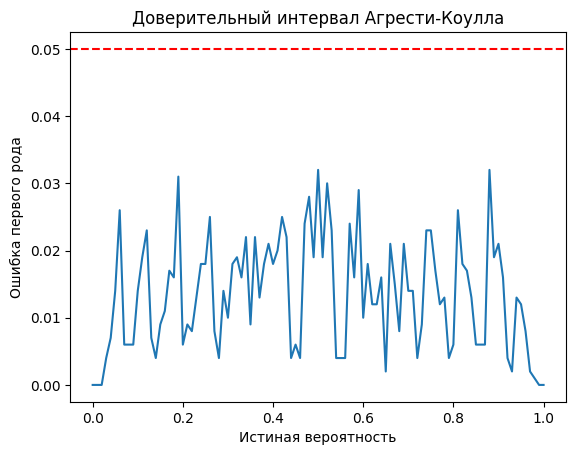

In [9]:
plt.plot(p, err_agresty)
plt.axhline(0.05, color='red', linestyle='dashed')
plt.xlabel('Истиная вероятность')
plt.ylabel('Ошибка первого рода')
plt.title('Доверительный интервал Агрести-Коулла');

__г) [5 баллов]__ С помощью [метода стабилизации дисперсии](https://youtu.be/JGNwZKwE2h0) для $p$ можно получить следующий доверительный интервал:

$$
\sin^2 \left(\arcsin \sqrt{\hat p} \pm \frac{z_{cr}}{2 \sqrt{n}} \right).
$$

Проведите для него тот же самый эксперимент.

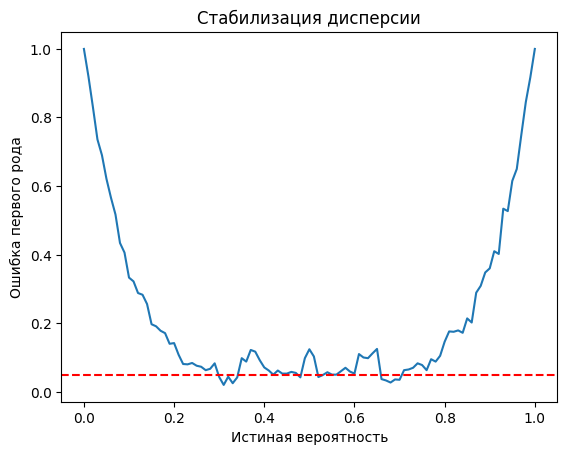

In [10]:
def ci_stab(p, n_obs=10, alpha=0.05, n=1000):
    z = sts.norm().ppf(1 - alpha/2)
    x = sts.bernoulli.rvs(p, size=(n, n_obs))

    p_hat = x.mean(axis=1)
    a = (np.sin(np.arcsin(p_hat ** 0.5) - z / 2 / np.sqrt(n_obs))) ** 2
    b = (np.sin(np.arcsin(p_hat ** 0.5) + z / 2 / np.sqrt(n_obs))) ** 2

    error = 1 - np.mean(((a < p) & (p < b) & (a < b)) | ((b < p) & (p < a) & (b < a)))
    length = np.mean(abs(a - b))
    return error, length

# за циклы тут не караем, главное смысл
p = np.arange(0, 1.01, 0.01)
err_stab, length_stab = np.vectorize(ci_stab)(p)

plt.plot(p, err_stab)
plt.axhline(0.05, color='red', linestyle='dashed')
plt.xlabel('Истиная вероятность')
plt.ylabel('Ошибка первого рода')
plt.title('Стабилизация дисперсии');

Всё сразу на одной картинке:

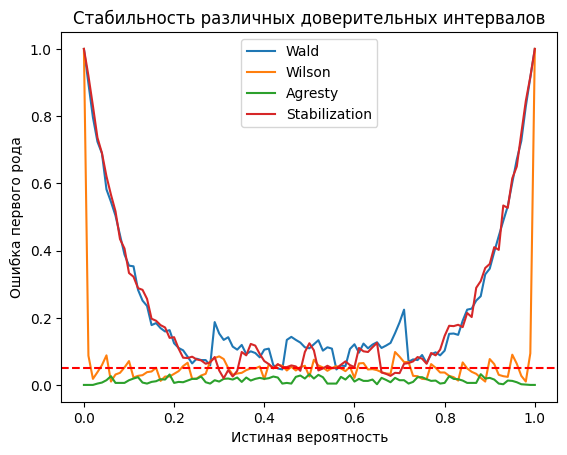

In [11]:
plt.plot(p, err_wald, label='Wald')
plt.plot(p, err_wilson, label='Wilson')
plt.plot(p, err_agresty, label='Agresty')
plt.plot(p, err_stab, label='Stabilization')

plt.axhline(0.05, color='red', linestyle='dashed')
plt.xlabel('Истиная вероятность')
plt.ylabel('Ошибка первого рода')
plt.title('Стабильность различных доверительных интервалов')
plt.legend();

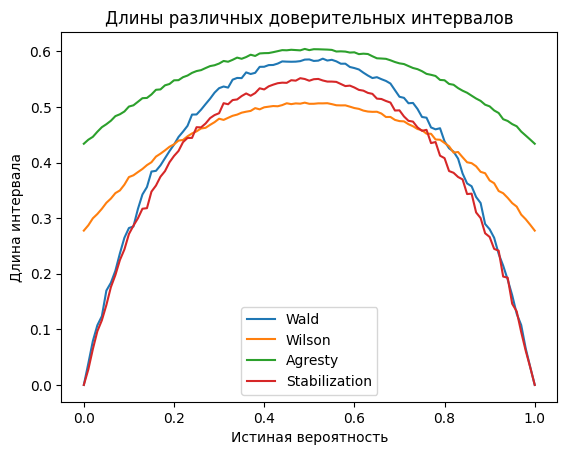

In [13]:
plt.plot(p, length_wald, label='Wald')
plt.plot(p, length_wilson, label='Wilson')
plt.plot(p, length_agresty, label='Agresty')
plt.plot(p, length_stab, label='Stabilization')

plt.xlabel('Истиная вероятность')
plt.ylabel('Длина интервала')
plt.title('Длины различных доверительных интервалов')
plt.legend();

__д) [5 баллов]__ Дайте развёрнутый ответ на следующие вопросы.

1. Правда ли, что при уровне доверия 95\% центры интервала Агрести — Коулла и Вильсона совпадают?

__Ответ:__ Нет, не совпадают. Для интервала Вильсона центр это $\frac{p^*n+\frac{z^2}{2}}{n+z^2}$, а для интервала Агрести-Коулла $\frac{p^*n+2}{n+4}$. Для уровня доверия 95% это разные (хотя и близкие) числа.

2. Какой 95\%-й интервал шире, Агрести—Коулла или Вильсона?

__Ответ:__ Интервал Агрести-Коулла несколько шире за счёт того, что в нём информативность выборки снижается разбавлением фиктивными нулями и единицами.

3. Какой 95\%-й интервал шире, Вальда или основанный на стабилизации дисперсии?

__Ответ:__ Интервал Вальда шире.

4. Как доверительные интервалы ведут себя на краях? Как они ведут себя в середине?

__Ответ:__ Все интервалы разваливаются на краях. В середне всё нормально. Интервал Агрести-Коула за счёт фиктивных наблюдений выдаёт ошибку сильно ниже заявленной, но это достигается за счёт увеличения его ширины.

5. Перезапустите код при $n=100$. Насколько драматично изменилась картинка?

__Ответ:__ Изменения заметны, особенно в случае со стабилизацией дисперсии - всё стало намного лучше. Другие методы построения интервала тоже показали лучшие результаты, что и немудрено - ЗБЧ гласит, что чем больше наблюдений в выборке, тем ближе их среднее будет к матожиданию, из чего следует, что это матожидание удастся лучше локализовать.

Что почитать:

- [Статья Денга про дельта-метод](https://alexdeng.github.io/public/files/kdd2018-dm.pdf)
- [Выводим распределение для дисперсии и строим асимптотические доверительные интервалы](https://www.stat.umn.edu/geyer/s06/5102/notes/ci.pdf) (тут же есть про стабилизацию дисперсии и многое другое)
- [Доверительный интервал Уилсона](https://www.econometrics.blog/post/the-wilson-confidence-interval-for-a-proportion/)
- [Доверительный интервал Агрести-Коула](https://www.econometrics.blog/post/don-t-use-the-textbook-ci-for-a-proportion/)
- [Сравниваем разные доверительные интервалы для долей](https://www.ime.usp.br/~jmsinger/Textos/Castroetal2019.pdf)

## Задача 2: квантильное преобразование (10 баллов)

Компьютер хорошо умеет генерировать равномерные случайные величины. Для разных популярных распределений, вроде нормального, люди также смогли придумать хорошие генераторы. Но что делать, если нам хочется научиться генерировать что-то специфическое? В этом людям помогает квантильное преобразование!

#### Теорема:

Пусть функция распределения $F_X(x)$ непрерывна. Тогда случайная величина $Y = F(X)$ имеет равномерное распределение на отрезке $[0; 1]$.


#### Следствие:

Пусть $Y \sim U[0;1]$, а $F(x)$ произвольная функция распределения. Тогда случайная величина $X = F^{-1}(Y)$ будет иметь функцию распределения $F(x)$.


#### Что это нам даёт:


- Позволяет генерировать из равномерного распределения другие. Достаточно найти обратную функцию и вычислить её значение от каждого элемента в выборке.
- Применимо невсегда, напрмер, для нормального распределения используют другие алгоритмы, так как функцию распределения для него невозможно записать аналитически.

<center>
<img src="https://raw.githubusercontent.com/FUlyankin/matstat-AB/main/week05_LLN_CLT/image/quant.png" height="200">
</center>


__Полезные видео и код:__

- [Видео с объяснением квантильного преобразования](https://www.youtube.com/watch?v=Dxtj-3N22_A&list=PLCf-cQCe1FRyg1ajZ2HJVKknbuTujBOLN&index=9)
- [Видео с его использованием в питоне](https://www.youtube.com/watch?v=ivpWyorfWlA&list=PLCf-cQCe1FRyg1ajZ2HJVKknbuTujBOLN&index=10)
- [Тетрадка с кодом из видео](https://github.com/FUlyankin/matstat-AB/blob/main/week05_LLN_CLT/09_python_distributions.ipynb)
- [Лекция Фила из маги по терверу с подробным разбором квантильного преобразования и выведением функции распределения максимума](https://www.youtube.com/watch?v=vvpRREpe0Bw)
- [Выведение функции распределения для максимума в учебнике Черновой](https://tvims.nsu.ru/chernova/tv/lec/node68.html)


Пуcть у нас есть стрёмная функция распределения:

$$
F(x) = \left( \frac{\ln x}{\ln \theta} \right)^{\alpha},  \quad x \in [1; \theta]
$$

__а) [5 баллов]__ Сгенерируйте из него выборку с помощью квантильного преобразования. Параметры $\alpha$ и $\theta$ возьмите на свой вкус. Для получившейся выборки постройте гистограмму.


$$
F^{-1}(y) = exp(y^{\frac{1}{\alpha}} \cdot \ln \theta)
$$

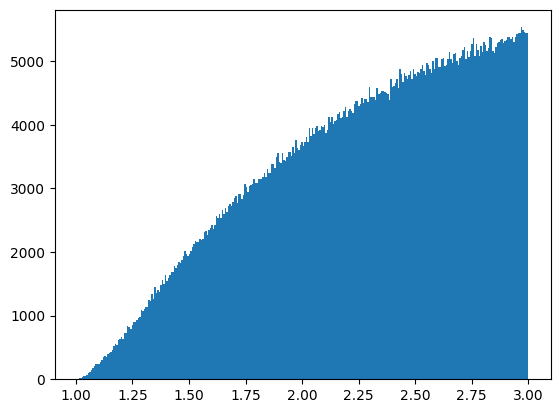

In [16]:
alpha = 2.7
theta = 3

y = sts.uniform().rvs(size=10**6)
x = np.exp(y ** (1/alpha) * np.log(theta))

plt.hist(x, bins=300);

__б) [5 баллов]__ Пусть случайные величины $X_1, \ldots, X_n \sim U[0;1].$ Пусть $Y_n = max(X_1, \ldots, X_n).$

Мы знаем, что $F_{Y_n}(x) = x^n,$ если $x \in [0; 1].$

Напишите функцию, которая сгенерирует с помощью квантильного преобразования выборку из распределения $F_{Y_n}(t)$.

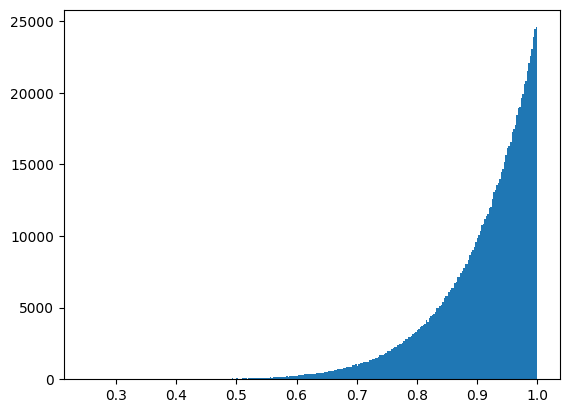

In [17]:
n = 10

y = sts.uniform().rvs(size=10**6)
x = y ** (1 / n)

plt.hist(x, bins=300);

## Задача 3: метрика плохих показов (60 баллов)

Мало того, что в интернете постоянно кто-то не прав, так ещё и куча спама, фейков, хейтспича, кликбейта и другого «плохого» контента. Каждая уважающая себя платформа борется с ним. Более того, гиганты вроде Facebook публикуют [transparency-отчёты](https://transparency.fb.com/reports/community-standards-enforcement/) о том, сколько показов «плохого» контента пропустила их система модерации.

Давайте представим себе, что мы Youtube. Мы хотим, чтобы пользователям как можно реже показывался «плохой» контент (например, спам или порно).

К сожалению, мы не можем сделать ручную разметку всех видео, которые загружают люди. Поток нового видео на платформе постоянно растёт. Нам надо будет поддерживать огромный штат модераторов. Поэтому для каждого нарушения, с помощью машинного обучения, обычно делают классификаторы. Нейросети пытаются предсказать, есть ли в видео неприемлимый контент. Если его вероятность высокая, видео автоматически банится. Если нейросеть не уверена, видео отправляют на разметку модераторам. Если мы обучим хороший классификатор, подавляющая часть потока будет оставаться без модерации.

Параллельно с классификатором мы можем начать размечать модераторами жалобы и самые вирусные видосы. Машинное обучение даёт осечки. Какое-то одно «плохое» видео, пропущенное нашей системой, может набрать много показов. Постмодерация самых вирусных видео и жалоб могут нас от этого спасти.

Нам хотелось бы понимать, насколько хорошо работает система модерации. Для этого мы будем оценивать долю «плохих» показов. Если мы показываем видео со спамом, такие показы мы считаем плохими.

**Наша задача**  —  получить несмещённую оценку доли плохих показов на youtube, а также построить для неё доверительный интервал. Тогда мы будем видеть, с каким нарушением у нас больше всего проблем, а также сможем придумывать для системы модерации разные улучшения и понимать, насколько они эффективны.

#### 1. Данные

У нас есть данные о просмотре видео на youtube за сутки. Таблица весьма громадная, так как она содержит несколько миллиардов уникальных видео. Мы хотим выбрать из неё тысячу случайных видео, чтобы модераторы разметили их на спам. При этом, нам нужно учесть частоту просмотров. Популярные видео должны иметь больше шансов попасть в подвыборку. Тогда по этой разметке мы сможем оценить долю плохих показов.

|      video                         |            shows                  |
|:----------------------------------:|:---------------------------------:|
| Baby Shark                         |  13 840 000 000                   |
| Despacito                          |   8 340 000 000                   |
| Johny Johny Yes Papa               |   6 850 000 000                   |
| ........                           |   ........                        |
| 1. Андан-2025: симуляции           |   2                               |

Давайте посчитаем для каждого видео вероятность, что оно будет показно и сделаем `np.random.choice`, как в коде ниже.

In [18]:
import numpy as np
import pandas as pd
import scipy.stats as sts

In [19]:
# сгенерируем показы из распределения Парето, чтобы было побольше выбросов как в жизни.
n_obs = 10**6

b = 0.7
rv = sts.pareto(b)
shows = np.round(rv.rvs(n_obs))
shows # это показы

array([6., 2., 2., ..., 2., 7., 4.])

In [20]:
videos = np.arange(1, n_obs + 1) # это id видео
videos

array([      1,       2,       3, ...,  999998,  999999, 1000000])

In [21]:
p = shows / shows.sum() # это вероятность того что видео будет показано
p

array([8.75500571e-09, 2.91833524e-09, 2.91833524e-09, ...,
       2.91833524e-09, 1.02141733e-08, 5.83667047e-09])

In [22]:
# генерируем выборку без повторений из 100 видео с учётом показов (более частые видео попадут в выборку вероятнее)
k = 100
np.random.choice(videos, size=k, replace=False, p = p)

array([917219, 694410, 962144, 144716, 734806, 785112, 476674, 666266,
       517573,  16289, 876974, 406337, 661690, 833025, 436002, 263408,
       524803, 953715, 932150, 307005, 803203, 666436,  83065, 416435,
       863990, 207670, 844241, 726555, 666580,  51233, 470317, 383304,
       795961, 379074, 564868,  10245, 926006, 685269,  33084, 169886,
       889099, 378361, 792590, 179943, 711625, 790650, 481057, 451993,
       423796, 704286, 417056, 114531, 752745, 903871, 920994, 711888,
       571732, 214458, 804972, 138785, 338729, 244575, 452317, 413317,
       500686, 437213, 193869, 794870, 866062, 820493,  81617, 997557,
       814900, 995506, 875866, 881749, 211092, 347932, 614159, 410263,
       958300,  98350,  55711, 132725, 913089, 536504, 158524, 491018,
       425666, 807435,  88716, 661061, 718550, 833759, 767856, 991672,
        80081, 255568, 345129, 321217])

У такого подхода есть проблема. Если в таблице миллиарды строк, мы не сможем сохранить таблицу в оперативную память. Нам для генерации выборки понадобится супер-компьютер. Хотелось бы этого избежать. К счастью, для решения этой проблемы есть [много алгоритмов,](https://en.wikipedia.org/wiki/Reservoir_sampling) и мы с вами реализуем один из них.

#### 2. Сэмплирование с повторениями

Для начала поработаем с сэмплированием с повторениями. Сгенерируем таблицу с данными.



In [23]:
np.random.seed(42)
n_obs = 10**5

b = 0.7
rv = sts.pareto(b)

df = pd.DataFrame.from_dict({
    'video_id': np.arange(1, n_obs + 1),
    'shows': np.round(rv.rvs(n_obs)),
    'is_spam': np.random.binomial(1, 0.30, n_obs), # пусть в 30% видео встречается спам
})

print(df.shape)
df.head()

(100000, 3)


,video_id,shows,is_spam
0,1,2.0,0
1,2,74.0,0
2,3,7.0,0
3,4,4.0,0
4,5,1.0,0


__а) [5 баллов]__  Посчитайте по табличке `df` истиную долю плохих показов:

$$
p_{\text{bad}} = \frac{\sum_{v \in V} \text{show}(v) \cdot \text{isSpam}(v) }{\sum_{v \in V} \text{show}(v)}.
$$

In [24]:
p_bad_real = (df['is_spam']*df['shows']).sum()/df['shows'].sum()
p_bad_real

0.21062855303523043

Мы не знаем всех меток $\text{is\_spam}(v)$. Мы можем позволить себе разметить маленький сэмпл, $S ⊂ V$. Каждое видео попадает к нам в сэмпл пропорционально числу его показов. Поэтому логично оценить долю плохих показов как

$$
\hat{p}_{\text{bad}} = \frac{1}{|\text{S}|}\sum_{v \in S} \text{isSpam}(v).
$$

__б) [10 баллов]__ С помощью функции `np.random.choice` cделайте $10^4$ выборок __с повторениями__ размера $1000$.

Постройте для каждой оценку доли плохих показов. Считайте, что модератор во время разметки безошибочно определяет значение из колонки `is_spam`.

Нарисуйте гистограмму для получившегося распределения. Отметьте на ней настоящую долю плохих показов и получившееся у вас среднее. Правда ли, что мы получили несмещённую оценку?

**Hint:** Перейдите от `pandas` к `numpy` и обратите внимание на команду `argsort()`. Такой код будет работать быстрее.

In [25]:
from tqdm.notebook import tqdm

n_obs = 10**4
p_bad = np.zeros(n_obs)

is_spam = df['is_spam'].values
shows = df['shows'].values
p = shows/shows.sum()

for i in tqdm(range(n_obs)):
    args = np.random.choice(np.arange(p.size), size=1000, replace=True, p = p)
    sample_is_spam = is_spam[args]
    shows_is_spam = shows[args]
    p_bad[i] = sample_is_spam.mean()

  0%|          | 0/10000 [00:00<?, ?it/s]

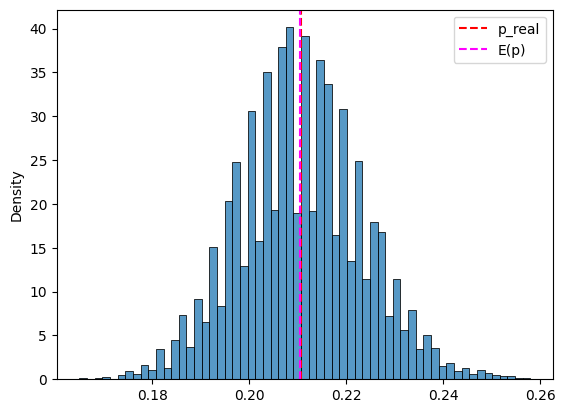

In [26]:
sns.histplot(p_bad, stat="density")

plt.axvline(x=p_bad_real, ymin=0, ymax= 60,
            color='red', linestyle='dashed', label='p_real')

plt.axvline(x=p_bad.mean(), ymin=0, ymax= 60,
            color='magenta', linestyle='dashed', label='E(p)')
plt.legend();

In [27]:
p_bad_real - p_bad.mean()

4.935303523037615e-05

#### 3. Сэмплирование без повторений

Выше мы сказали, что делать `np.random.choice` для огромных таблиц невозможно, так как они не поместятся в оперативную память.

Более того, нам надо дать модераторам разметить видео на спам. Многие видео будут повторяться. Уникальных видео каждый раз будет разное количество. Нагрузка на модераторов будет неравномерной. Они будут жаловаться на это. Хочется, чтобы нагрузка всегда была одинаковой.

Давайте сменим подход и будем делать **случайную взвешенную выборку БЕЗ ПОВТОРЕНИЙ.** Это означает, что наблюдения зависят друг от друга. Причём корреляция между ними довольно высокая. Это будет приводить к проблемам.

Пусть у нас есть $n$ объектов. Мы хотим отобрать $k$ видео для разметки модераторами. Использование `np.random.choice` можно проинтерпретировать следующим образом:

1. Напишем название $i-$го видео на разных табличках $\text{shows}_i$ раз.
2. Случайно перемешаем все таблички и положим их в стопку в случайном порядке.
3. Будем отбирать самые верхние таблички до тех пор, пока не встретим $k$ разных названий видео.

Если бы нам были бы не важны веса в виде показов, каждое видео попадало бы к нам в выборку равновероятно. Мы могли бы отобрать выборку размера $k$ следущим образом:

1. Для каждого видео генерируем $X_i \sim U[0; 1]$ (по одной табличке на видео).
2. Сортируем все видео по сгенерированной случайной величине.
3. Срезаем топ-k видео в итоговую выборку.

Веса в виде показов для нас важны. В теринах равномерных случайных величин алгоритм с весами можно записать так:

1. Для $i$-го видео генерируем $\text{shows}_i$ независимых равномерных случайных величин (для каждого видео свое число табличек).
2. Складываем все таблички в одну стопку и сортируем их по сгенерированным величинам.
3. Идём по массиву от больших элементов к меньшим и отбираем видео, пока не накопим $k$ элементов.

Очень не хочется для какого-нибудь популярного видео генерировать несколько миллиардов случайных чисел. Конечно же, сразу нужно генерировать случайную величину, которая будет максимумом нескольких независимых равномерных случайных величин. На итоговую сортировку это никак не повлияет. Мы отберём те же самые видео.  



Сгенерировать для каждого видео $X_{i,max}$ можно с помощью квантильного преобразования.

Пусть случайные величины $X_1, \ldots, X_m \sim \text{iid} \, U[0;1].$ Пусть $Y = \max(X_1, \ldots, X_m).$

Мы знаем, что $F_{Y}(x) = x^m,$ если $x \in [0; 1].$ Выборку из распределения $F_{Y}(x)$ можно сгенерировать в два шага:

- $x_1, \ldots, x_m \sim \text{iid} \, U[0;1]$
- $y_i = x_i^{\frac{1}{m}}$

__в) [10 баллов]__ Фактически нам надо отсортировать все видео по величине $X_i^{\frac{1}{\text{shows}_i}}$, где $X_i \sim U[0;1]$, и отобрать топ-$k$ видео в выборку для разметки модераторами. Сделайте, используя эту процедуру, для таблицы `df` сэмпл размера $100$.

In [28]:
df['uniform'] = sts.uniform(0,1).rvs(df.shape[0])
df['x_max'] = df['uniform']**(1/df['shows'])

df_sample = df.sort_values('x_max', ascending=False)[:100]
df_sample['shows'].apply(np.log).describe()

,shows
count,100.000000
mean,9.480415
std,3.315466
min,0.693147
25%,7.702013
50%,10.578835
75%,11.693821
max,16.773387


__г) [5 баллов]__ Вычислять на компьютере корни из числа, лежащего между 0 и 1 не очень удобно с точки зрения округления. Могут возникать большие ошибки.

Гораздо эффективнее отобрать топ по величине $\frac{1}{\text{shows}_i} \cdot \ln X_i$, где $X_i \sim U[0;1]$. Проделайте это.

In [29]:
df['ln_x_max'] = (1/df['shows'])*np.log(df['uniform'])

sample01 = set(df.sort_values('x_max', ascending=False)[:100].video_id.values)
sample02 = set(df.sort_values('ln_x_max', ascending=False)[:100].video_id.values)

len(sample01 & sample02)

100

Такую процедуру можно найти в продакшн-процессах у многих компаний. В Яндексе похожая процедура используется для сэмплирования поисковых запросов для дальнейшей разметки. [В статье](https://yadi.sk/i/IxKLPFEj3TSpPe) можно найти доказательство того, что алгоритм даст корректную вероятность для каждого видео.

В примере выше, мы держим табличку в оперативной памяти компьютера. Это игрушечный пример, и это позволительно. В реальной жизни мы можем считывать строки с жесткого диска, для каждой из них по очереди генерировать случайную величину и поддерживать топ-к уникальных видео в памяти. Например, в этом может помочь такая структура данных [как куча.](https://ru.wikipedia.org/wiki/Куча_(структура_данных))

#### 4. Оценка доли плохих показов

Дальше нам остаётся разметить видео и аккуратно посчитать итоговую метрику. Беда будет в том, что она окажется смещённой.

__д) [10 баллов]__ Сделайте $10^4$ выборок размера $1000$. Постройте для каждой оценку доли плохих показов. Считайте, что модератор во время разметки безошибочно определяет значение из колонки `is_spam`.

Нарисуйте гистограмму для получившегося распределения. Отметьте на ней настоящую долю плохих показов и получившееся у вас среднее. Правда ли, что они сильно отличаются друг от друга? Найдите среднее смещение оценки.

In [30]:
from tqdm.notebook import tqdm

n_obs = 10**4
p_bad = np.zeros(n_obs)

is_spam = df['is_spam'].values
shows = df['shows'].values
p = 1/shows

for i in tqdm(range(n_obs)):
    ln_x_max = p * np.log(sts.uniform(0,1).rvs(df.shape[0]))
    args = ln_x_max.argsort()[::-1][:1000]
    sample_is_spam = is_spam[args]
    shows_is_spam = shows[args]
    p_bad[i] = sample_is_spam.mean()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [31]:
p_bad.mean()

0.3074001

In [32]:
p_bad_real

0.21062855303523043

In [33]:
(p_bad - p_bad_real).mean()

0.09677154696476957

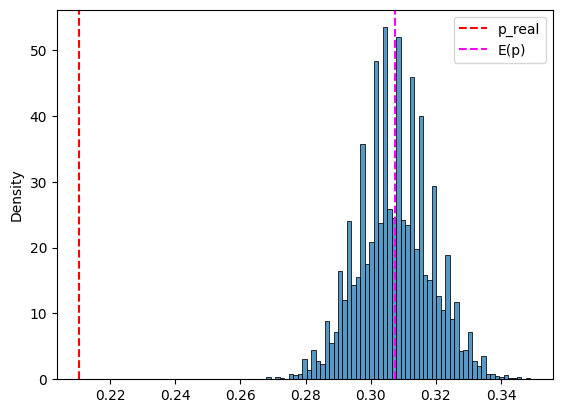

In [34]:
sns.histplot(p_bad, stat="density")

plt.axvline(x=p_bad_real, ymin=0, ymax= 60,
            color='red', linestyle='dashed', label='p_real')

plt.axvline(x=p_bad.mean(), ymin=0, ymax= 60,
            color='magenta', linestyle='dashed', label='E(p)')
plt.legend();

**Откуда появляется это смещение?** Представим себе, что у нас есть случайная величина $X$, которая принмает пять значений с вероятностями

<center>

|  $X$         | $x_1$   | $x_2$ | $x_3$ | $x_4$    | $x_5$    |
|:------------:|:-------:|:-----:|:-----:|:--------:|:--------:|
| $P(X = x)$   | $^1/_2$ |$^1/_4$|$^1/_8$|$^1/_{16}$|$^1/_{16}$|

</center>

Если мы делаем выборку с повторениями, как часто туда будет попадать элемент $x_1$? Элемент попадает в выборку с вероятностью $^1/_2.$ Будем вытаскивать из выборки элементы до тех пор, пока $x_1$ не окажется в наших руках. Номер попытки, начиная с которой $x_1$ окажется у нас, имеет геометрическое распределение. Если $Y \sim \text{Geom}(p),$ тогда $\mathbb{E}(Y) = \frac{1}{p}.$

Получается, элемент $x_1$ окажется в нашей выборке в среднем на второй попытке. Если бы мы делали выборку с повторениями, каждый второй элемент в ней был бы равен $x_1,$  каждый четвёртый был бы равен $x_2$, каждый восьмой был бы равен $x_3$ и так далее. Обратим внимание, что если мы делаем выборку из трёх элементов без повторений, то чаще всего мы будем работать с выборкой $x_1, x_2, x_3$.

В ситуации с видео, мы сэмплируем их пропорционально числу показов. В числе показов может быть очень сильный перекос. Какие-то видео показываются в рекомендательной системе десятки раз, а какие-то вирусятся и прорываются в тренды. Каждый раз, когда мы __без возвращения__ берём новое видео в выборку, мы как бы занижаем его вес в несмещённой выборке (выборке с повторениями).

#### 5. Исправляем смещение

На выборку без повторений размера $n$ можно смотреть следующим образом: мы генерируем выборку с возвращением до тех пор, пока количество уникальных элементов не достигнет числа $n$. При этом, если мы берём на каком-то шаге элемент уже выбранный ранее, мы не включаем его в выборку, а только отдельно запоминаем где-нибудь счётчик числа вхождений этого элемента $c_i$. При таком подходе несмещённую оценку доли плохого можно записать как

$$
\hat{p}_{\text{bad}} = \frac{\sum_{i=1}^{n} c_i \cdot \text{isSpam}(v_i)}{\sum_{i=1}^{n} c_i.}
$$

Если выборка имеет сильно неравномерные веса, то нам придётся довольно долго генерировать элементы с возвращением, пока мы наберём необходимое количество уникальных.

Поэтому вместо того, чтобы накапливать счётчики вхождений, мы рассчитаем их математическое ожидание по всем сгенерированным выборкам без повторений, имеющим такое же упорядоченное множество элементов $w_i = \mathbb{E}(c_i).$

Пусть $q_i = \frac{show(v_i)}{\sum_{j=1}^{|V|} show(v_j)}$,пусть $w_i^k$ —  количество вхождений элемента с индексом $i$ к моменту, когда в выборке набралось $k$ уникальных элементов. Пусть уникальные элементы попадают в выборку в порядке $v_1, v_2, v_3, \ldots, v_n$.

Когда мы возьмём первый элемент:

$$
w_1^1 =1, \quad w_2^1 = 0, \quad w_3^1 = 0, \quad \ldots, \quad w_n^1 = 0.
$$

Прежде, чем мы достанем второй уникальный элемент, мы, в среднем, достанем первый элемент ещё  $\frac{1}{1 - q_1} - 1 = \frac{q_1}{1 - q_1}$ раз.

Эту величину мы посчитали с помощью геометрического распределения. В качестве успешного события мы рассматриваем второй уникальный элемент. Вероятность успеха равна $1- q_1.$ Геометрическая случайная величина представляет из себя номер первого успешного события. Если мы хотим получить число не успешных событий, надо вычесть единицу.

Получаем

$$
w_1^2 = 1 + \frac{q_1}{1 - q_1}, \quad w_2^2 = 1, \quad w_3^2 = 0, \quad \ldots, \quad w_n^2 = 0.
$$

Прежде, чем мы достанем третий уникальный элемент, мы, в среднем, достанем первые два элемента ещё $\frac{1}{1 - (q_1 + q_2)} - 1 = \frac{q_1 + q_2}{1 - (q_1 + q_2)}$ раз. Из них доля доставания первого элемента составляет $\frac{q_1}{q_1 + q_2}$, а доля второго $\frac{q_2}{q_1 + q_2}$.

Получаем

$$
w_1^3 = 1 + \frac{q_1}{1 - q_1} + \frac{q_1}{1 - (q_1 + q_2)}, \quad w_2^3 = 1 + \frac{q_2}{1 - (q_1 + q_2)}, \quad  w_3^3 = 1, \quad \ldots, \quad w_n^3 = 0.
$$

Продолжая эту логику до шага $n,$ получаем формулу

$$
c_i = w_i^n = 1 + q_i \cdot \left( \sum_{j=i}^{n-1} \frac{1}{1 - \sum_{k=1}^j q_k} \right).
$$

Подставим эти веса вместо счетчиков $c_i$. Это даст нам несмещённую оценку доли «плохих» показов на основе разметки ровно $n$ объектов

$$
\hat p_{\text{bad}} = \frac{\sum_{i=1}^n \left[ 1 + q_i \cdot \left( \sum_{j=i}^{n-1} \frac{1}{1 - \sum_{k=1}^j q_k} \right) \right] \cdot isSpam(v_i)}{\sum_{i=1}^n \left[ 1 + q_i \cdot \left( \sum_{j=i}^{n-1} \frac{1}{1 - \sum_{k=1}^j q_k} \right)  \right]},  \quad q_i = \frac{show(v_i)}{\sum_{j=1}^{|V|} show(v_j)}.
$$



__е) [10 баллов]__ Пришло время закодит, полученные выше веса. Сделайте $1000$ выборок без повторений размера $1000$. Постройте для каждой оценку доли плохих показов. Убедитесь, что оценка, предложенная выше, окажется несмещённой.

**Hint:** для расчёта весов удобно воспользоваться несколько раз функцией `np.cumsum`.

In [35]:
# внимательно изучите этот код:

a = np.array([2, 3, 4, 5])
np.cumsum(a[:-1][::-1])[::-1]

array([9, 7, 4])

In [36]:
from tqdm.notebook import tqdm

n_obs = 10**4
p_bad = np.zeros(n_obs)
p_bad2 = np.zeros(n_obs)
p_bad3 = np.zeros(n_obs)

p_var = np.zeros(n_obs)

is_spam = df['is_spam'].values
shows = df['shows'].values
p = 1/shows
q = shows/shows.sum()

In [37]:
for i in tqdm(range(n_obs)):
    ln_x_max = p * np.log(sts.uniform(0,1).rvs(df.shape[0]))

    args = ln_x_max.argsort()[::-1][:1000]
    sample_is_spam = is_spam[args]
    sample_q = q[args]
    shows_q = shows[args]

    src = 1/(1 - np.cumsum(sample_q))
    src = np.cumsum(src[:-1][::-1])[::-1]
    c = 1 + sample_q*np.hstack((src, 0))

    p_bad[i] = (c * sample_is_spam).sum()/c.sum()
    p_var[i] = (c**2).sum()/(c.sum()**2) * p_bad[i] * (1 - p_bad[i])

    p_bad2[i] = sample_is_spam.mean()
    p_bad3[i] = (sample_is_spam*shows_q).sum()/shows_q.sum()


  0%|          | 0/10000 [00:00<?, ?it/s]

In [38]:
p_bad_real

0.21062855303523043

In [39]:
p_bad.mean() # неудачный нейминг, это p_super_puper_nice или p_kaef

0.21062718576172787

In [40]:
p_bad2.mean()

0.3073304

In [41]:
# Это тупо по показам посчитали. Надо написать в решении, что это фиговый подход
# И если возникает соблазн так делать то это кринж :)
p_bad3.mean()

0.205656171881358

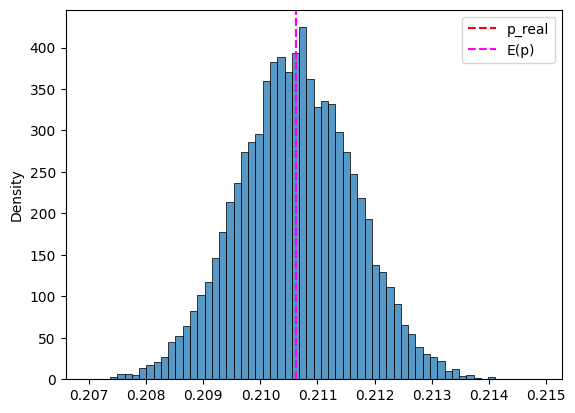

In [42]:
sns.histplot(p_bad, stat="density")

plt.axvline(x=p_bad_real, ymin=0, ymax= 60,
            color='red', linestyle='dashed', label='p_real')

plt.axvline(x=p_bad.mean(), ymin=0, ymax= 60,
            color='magenta', linestyle='dashed', label='E(p)')
plt.legend();

#### 6. Доверительный интервал

Про долю плохих заказов надо уметь делать выводы. Для этого надо построить доверительный интервал. Для него нужна дисперсия. Все карточки размечаются модераторами незвисимо друг от друга. Получается, что дисперсию можно найти как

$$
\text{Var}(\hat p_{\text{bad}}) = \frac{\sum_{i=1}^n c^2_i \cdot \text{Var}(\text{isSpam}(v_i))}{\left(\sum_{i=1}^n c_i\right)^2} = \frac{\sum_{i=1}^n c^2_i}{\left(\sum_{i=1}^n c_i\right)^2} \cdot p_{\text{bad}} \cdot (1 - p_{\text{bad}})
$$

Видно, что если сэмпл занимает небольшую долю выборки и показы распределены между элементами достаточно равномерно, то веса $c_i$ будут несильно отличаться от $1$. Тогда асимптотически, по мере роста размера сэмпла, стандартное отклонение метрики будет падать как $\frac{1}{\sqrt{n}}.$

Однако, если существенная доля показов в рекомендательной ленте представлена небольшой группой видосов, тогда веса будут существенно различаться и, начиная с определённого момента, увеличение размера выборки не будет давать заметного снижения разброса в оценке доли плохих показов.

__ё) [5 баллов]__ Сделайте $1000$ выборок без повторений размера $1000$. Постройте по каждой $95\%$ доверительный интервал для доли плохих показов.

Убедитесь, что он действительно покрывает долю плохих показов с вероятностью $0.95$.

In [51]:
alpha = 0.05
z = sts.norm().ppf(1 - alpha/2)

left = p_bad - z * np.sqrt(p_var)
right = p_bad + z * np.sqrt(p_var)

np.mean((p_bad_real <= right)&(p_bad_real >= left))

1.0

In [52]:
left

array([-0.162657  , -0.16238526, -0.16282256, ..., -0.16330489,
       -0.16240689, -0.16290919])

In [53]:
right

array([0.58402185, 0.58492751, 0.58312034, ..., 0.58100084, 0.585274  ,
       0.58287369])

In [54]:
(right - left).mean()

0.7465722735058744

In [55]:
(right > 1).sum()

0

In [57]:
(left < 0).mean() # лол

1.0

__ж) [5 баллов]__ Если вы всё сделали всё верно, выше симуляции дали очень плохой результат. Доверительный интервал развалился. Он оказался слишком широким. Более того, он пробивает слева ноль.

Сконструируйте доверительный интервал Уилсона. Убедитесь, что он больше не пробивает отрезок $[0;1]$.

In [64]:
# Важно: баллы за этот пукнт ставим всем, тут интервал надо выводить и аккуратно
# пихать веса в формулу, я когда составлял думал что достаточно сделать как ниже,
# это неправда, к сожалению

u = n_obs / (n_obs + z**2)
n_w = n_obs + z**2

p_bad_w = u * p_bad + (1 - u) * 0.5
std_hat_w = np.sqrt(u * p_var + (1 - u) * (0.5 **2 ) / n_w)
left = p_bad_w - z * std_hat_w
right = p_bad_w + z * std_hat_w

In [65]:
(right - left).mean()

0.7464290172479922

In [66]:
np.mean((p_bad_real <= right)&(p_bad_real >= left))

1.0

In [67]:
left # тут достаточно было сделать так, кажется тут с весами надо аккуратнее быть

array([-0.16247426, -0.16220269, -0.16263969, ..., -0.16312167,
       -0.16222434, -0.16272627])

In [68]:
right

array([0.58406131, 0.58496668, 0.58316007, ..., 0.58104123, 0.58531307,
       0.58291351])

Доверительный интервал Уилсона всё еще не будет давать нужного уровня значимости из-за огромной ширины. Нам нужен какой-то способ уменьшить дисперсию. Это можно сделать с помощью машинного обучения.

#### 7. Уменьшение дисперсии с помощью машинного обучения

Этот раздел вам нужно просто проичитать. Вы уже достаточно настрадались, решая пункты выше.

Когда для маленькая, дисперсия оценки доли будет довольно высокой. Относительная ошибка в оценке быстро растёт при уменьшении доли размечаемых видосов, содержащих спам

$$
\frac{\sigma}{p_{\text{bad}}} \approx \frac{\sqrt{ p_{\text{bad}} \cdot (1 -  p_{\text{bad}})/n} }{ p_{\text{bad}} } \approx \frac{1}{\sqrt{n \cdot p_{\text{bad}}}}.
$$

Например, если реальная доля показов, содержащих спам составляет $0.5\%,$ то при разметке выборки из $1000$ видео стандартное отклонение составить $0.22\%$ и положительную метку будут обычно получать $3-7$ видео, а наша оценка доли спама будет колебаться в пределах $(0.5 \pm 0.22)\%.$ При таком уровне шума отслеживать эффект от введения различных улучшений в пайплайнах модерации становится практически невозможно.

Однако, если бы у нас существовал способ повысить долю просэмплированных видео с положительной разметкой в сто раз, то мы бы получили оценку доли плохого в сэмпле равную $(50 \pm 1.6)\%.$

Принимая во внимание, что при построении сэмпла мы завысили долю плохого в сто раз, получаем, что реальная доля плохого составит  $(0.5 \pm 0.016)\%.$ То есть с помощью приоритизации мы могли бы снизить разброс примерно в $14$ раз.

На практике мы не можем заранее угадать какие видео будут размечены как плохие. Однако у нас есть ML-модели, предсказываютщие подозрительность видео. Например, вероятность того, что видос относится к плохому классу, $\text{score}(v_i)$.

Для того, чтобы сделать размечаемую выборку более представительной по классам, но при этом сохранить репрезентативность по потоку, повысим вероятность сэмплирования видео с высоким уровнем подозрительности.

Чтобы после этого по разметке сэмпла оценить долю плохого на потоке, нам нужно обратно изменить веса видео, чтобы величины соотвествовали ожидаемым значениям без перевзвешивания. Новые веса в формуле будут равны

$$
c_i = \sum_{i=1}^n  \frac{1 + q_i \cdot \left( \sum_{j=i}^{n-1} \frac{1}{1 - \sum_{k=1}^j q_k}\right)}{\text{score}(v_i)}, \quad q_i = \frac{\text{show}(v_i)}{\sum_{j=1}^{|V|} \text{show}(v_j)}
$$

Оценка доли будет искаться как

$$
\hat p_{spam} = \frac{\sum_{i=1}^n c_i \cdot \text{isSpam}(v_i)}{\sum_{i=1}^n c_i}.
$$

Аналогично дисперсия такой оценки будет иметь вид

$$
\text{Var}(\hat p_{\text{bad}}) = \frac{\sum_{i=1}^n c^2_i \cdot \text{Var}(\text{isSpam}(v_i))}{\left(\sum_{i=1}^n c_i\right)^2}.
$$

В формуле дисперсии $\text{Var}(\text{isSpam}(v_i))$ уже нельзя считать одинаковыми, так как есть зависимость между весом объекта, обусловленным $score(v_i)$ и дисперсией бернулиевской случайной величины $\text{isSpam}(v_i).$

Если предсказывающая модель обучена в точности на реальном распределении, наблюдаемом в потоке, то можно считать, что $\text{score}(v_i) = \mathbb{P}(\text{isSpam}(v_i) = 1).$

Тогда

$$
\text{Var}(\text{isSpam}(v_i)) = \mathbb{P}(\text{isSpam}(v_i) = 1) \cdot \mathbb{P}(\text{isSpam}(v_i) = 0) = \text{score}(v_i) \cdot (1 - \text{score}(v_i)).
$$

Модель должна быть в таком случае [откалибрована.](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem06-calibration.ipynb)

Если откалибровать модель не представляется возможным,тогда можно оценить математическое ожидание и дисперсию элемента на основе исторических данных по разметке элементов с похожими предсказаниями модели.

Если для какого-то объекта по каким-то причинам отсутствует $\text{score}(v_i),$ то при сэмплировании мы можем вставить ему произвольный вес и использовать верхнюю оценку на дисперсию бернуллиевской случайной величины, $\text{Var}(\text{isSpam}(v_i)) \le 0.25.$